In [78]:
%reset -sf

In [166]:
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import pyro
from pyro.contrib.autoguide import *
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, JitTrace_ELBO
import pyro.optim as optim
import pyro.poutine as poutine
import seaborn as sns
import torch
from torch.distributions.transforms import ExpTransform

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)

print(pyro.__version__)
print(torch.__version__)

plt.rcParams.update({'font.size': 16,
                     'xtick.labelsize': 14,
                     'ytick.labelsize': 14,
                     'axes.titlesize': 'large', 
                     'axes.labelsize': 'medium'})

0.4.0
1.2.0


## Dataset

Weekly unemployment insurance claim dataset that is provided by the Department of Labor (https://oui.doleta.gov/unemploy/claims.asp).

In [80]:
unemployment = pd.read_csv('data/unemployment_claims.csv')
unemployment['date'] = pd.to_datetime(unemployment['date'])
unemployment

,date,initial claim
0,2010-01-02,651215
1,2010-01-09,825891
2,2010-01-16,659173
3,2010-01-23,507651
4,2010-01-30,538617
5,2010-02-06,512463
6,2010-02-13,482078
7,2010-02-20,458160
8,2010-02-27,474662
9,2010-03-06,462679


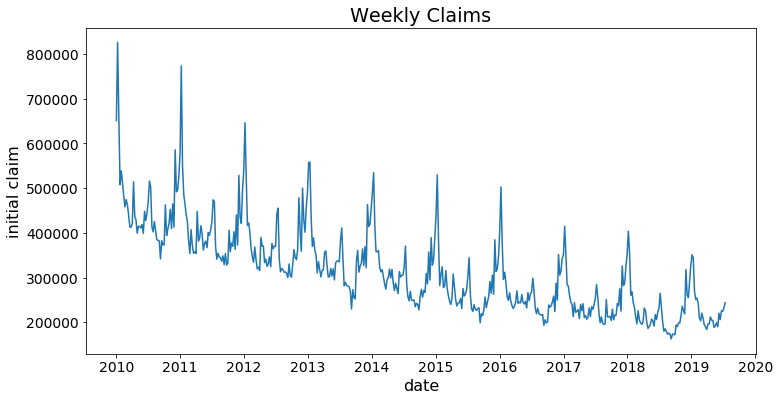

In [111]:
y = torch.tensor(unemployment['initial claim'].values, dtype=torch.float32)
y_train = y[:-200]


fig, ax = plt.subplots()
sns.lineplot(x='date', y='initial claim', data=unemployment, ax=ax).set_title('Weekly Claims');

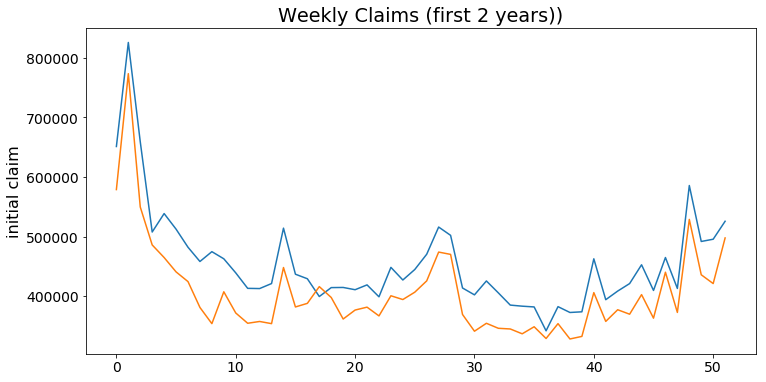

In [110]:
fig, ax = plt.subplots()
sns.lineplot(x=np.arange(52), y='initial claim', data=unemployment[:52], ax=ax).set_title('Weekly Claims (first 2 years))');
sns.lineplot(x=np.arange(52), y='initial claim', data=unemployment[52:104], ax=ax);

In [136]:
init_date = '2010-01-02'

## Seasonal Global Trend Models

Given some data, $y$ with seasonality $S$; at time $t$, the parameters of the Seasonal Global Trend (SGT) model are updated as follows, to generate the predicted $\tilde{y}_{t+1}$. 

$$
\begin{align}
\tilde{y}_{t+1} & \sim t(\nu, \hat{y}_{t+1}, \hat{\sigma}_{t+1}) \\
\hat{y}_{t+1} & = (l_t + \gamma l_{t}^{\tau_{trend}}) s_{t+1} \\
\hat{\sigma}_{t+1} &= \sigma \hat{y}_{t+1}^{\tau_{var}} \\
l_{t+1} &= \alpha \frac{y_t}{s_t} + (1 - \alpha) l_t \\
s_{t+1+S} &= \beta \frac{y_{t+1}}{l_{t+1}} + (1 - \beta) s_{t+1} \\
\end{align}
$$

We place appropriate priors on $\nu$, $\alpha$, $\beta$, $\gamma$, $\sigma$, $\tau_{trend}$ and $\tau_{var}$.

## Inference Using Automatic Variational Inference

### MAP Inference using a Delta Autoguide

In [137]:
def model_sgt_1(periodicity, y=None, predict_ahead=0, level=None, seasonality=None):
    """
    A bayesian model for time series forecasting using Seasonal Global Trend (SGT).
     - Note that `tau_var` is assumed to be 0.
    """
    assert (predict_ahead > 0) ^ (y is not None), \
        "Pass `y` for inference, or specify `predict_ahead` > 0 for prediction."
    S = periodicity
    nu = pyro.sample('nu', dist.Uniform(2, 20))
    sigma = pyro.sample('sigma', dist.HalfCauchy(1.))
    alpha = pyro.sample('alpha', dist.Beta(2., 2.)) 
    beta = pyro.sample('beta', dist.Beta(2., 2.))
    gamma = pyro.sample('gamma', dist.Normal(0., 1.))
    pow_trend = pyro.sample('pow_trend', dist.Beta(1., 2.))
    
    with pyro.plate('init_s', S):
        init_seasonality = pyro.sample('init_seasonality', dist.LogNormal(0., 1.))
        
    if y is not None:
        seasonality = [init_seasonality[i] for i in range(periodicity)]
        # populate (S + 1) th index
        seasonality.append(init_seasonality[0])
        level = [y[0] / init_seasonality[0]]
        start_idx = 1
    else:
        start_idx = len(level)
    
    forward_steps = len(y) - 1 if y is not None else predict_ahead

    for i in range(start_idx, start_idx + forward_steps):
        seasonality_cur = seasonality[i]
        assert seasonality_cur > 0
        level_prev = level[-1]
        y_hat = (level_prev + gamma * level_prev ** pow_trend) * seasonality_cur
        assert y_hat > 0, level
        d = dist.StudentT(nu, y_hat, sigma)
        obs_y = y[i] if y is not None else None
        y_pred = pyro.sample('y_{}'.format(i),
                             dist.StudentT(nu, y_hat, sigma),
                             obs=obs_y).clamp(min=0.)
        cur_level = alpha * (y_pred / seasonality_cur) + (1 - alpha) * level_prev
        level.append(cur_level)
        if not predict_ahead:
            assert (cur_level > 0).all(), "alpha: {}".format(alpha)
        seasonality_next = beta * (y_pred / cur_level) + (1 - beta) * seasonality_cur
        seasonality.append(seasonality_next)
        assert len(seasonality) == i + S + 1

    return [l.detach() for l in level], [s.detach() for s in seasonality]

In [138]:
pyro.clear_param_store()
pyro.set_rng_seed(1)
guide = AutoDelta(model_sgt_1)
opt = optim.Adam({'lr': 0.08})

svi = SVI(model_sgt_1, guide, opt, loss=Trace_ELBO())
periodicity = 52  # Use yearly periodicity

for i in range(1200):
    loss = svi.step(periodicity, y=y_train)
    if i % 100 == 0:
        print('ELBO loss: {}'.format(loss))
print('ELBO loss: {}'.format(loss))

ELBO loss: 35587.343999922276
ELBO loss: 6082.879361152649
ELBO loss: 3721.446375489235
ELBO loss: 3542.5040761232376
ELBO loss: 3493.391269981861
ELBO loss: 3460.7545171380043
ELBO loss: 3434.7690447568893
ELBO loss: 3431.849722325802
ELBO loss: 3428.922407448292
ELBO loss: 3424.2378119826317
ELBO loss: 3407.428692817688
ELBO loss: 3405.9118788838387
ELBO loss: 3405.0759221315384
ELBO loss: 3404.238040328026
ELBO loss: 3403.3887961506844
ELBO loss: 3402.5255452394485
ELBO loss: 3401.661255776882


In [139]:
@torch.no_grad()
def predict(model, guide, periodicity, y_train, predict_ahead=30, num_samples=100):
    """
    Generate `num_samples` predictions by sampling the parameters for the
    time series model from the approximate posterior.    
    """
    preds = []
    l, s = [], []
    for i in range(num_samples):
        guide_trace = poutine.trace(guide).get_trace(periodicity, y=y_train)
        replayed_model = poutine.replay(model, guide_trace)
        level, seasonality = replayed_model(periodicity, y=y_train)
        model_trace = poutine.trace(replayed_model).get_trace(periodicity, 
                                                              predict_ahead=predict_ahead,
                                                              level=level,
                                                              seasonality=seasonality)
        predictions = torch.stack([model_trace.nodes['y_{}'.format(i)]['value'] 
                                   for i in range(len(y_train), len(y_train) + predict_ahead)], 
                                  -1)
        preds.append(torch.cat([y_train, predictions]))
        l.append(torch.stack(level, -1))
        s.append(torch.stack(seasonality, -1))
    return torch.stack(preds), torch.stack(l), torch.stack(s)

In [140]:
num_samples = 500
predict_ahead = 200
preds, level, seasonality = predict(model_sgt_1, guide, periodicity, y_train, 
                                    predict_ahead=predict_ahead, num_samples=num_samples)

In [141]:
res1 = unemployment.copy()
test_time_range = pd.date_range(start=init_date, freq='7D', 
                                periods=len(y_train) + predict_ahead)
res1['type'] = 'Actual'
l_samples = np.hstack([level.detach().cpu().numpy(),
                       np.full((num_samples, len(preds[1]) - len(level[1])), np.nan)
                      ]).flatten()
s_samples = seasonality.detach().cpu().numpy()[:, :preds.shape[1]].flatten()
df = pd.DataFrame({
    'date': np.tile(test_time_range.values, num_samples),
    'initial claim': preds.flatten().detach().cpu().numpy(),
    'level': l_samples,
    'seasonality': s_samples,
})
df['type'] = 'Predicted'
res1 = res1.append(df, sort=True)

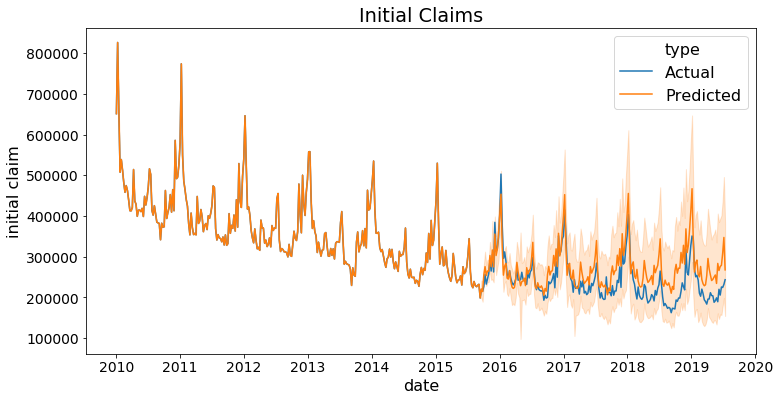

In [145]:
sns.lineplot('date', 'initial claim', hue='type', data=res1, ci='sd').set_title('Initial Claims');

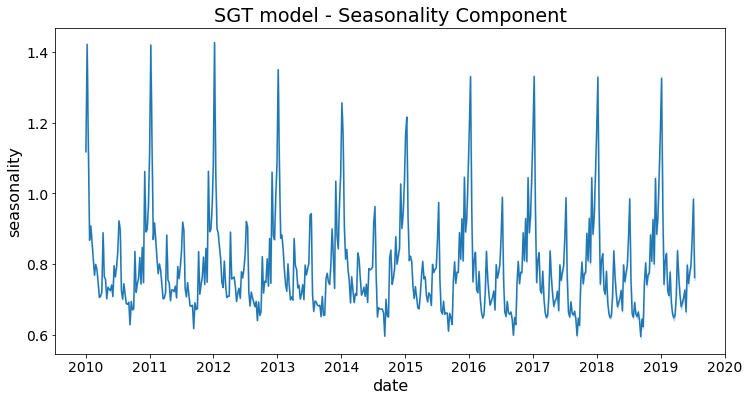

In [146]:
sns.lineplot('date', 'seasonality', data=res1).set_title('SGT model - Seasonality Component');

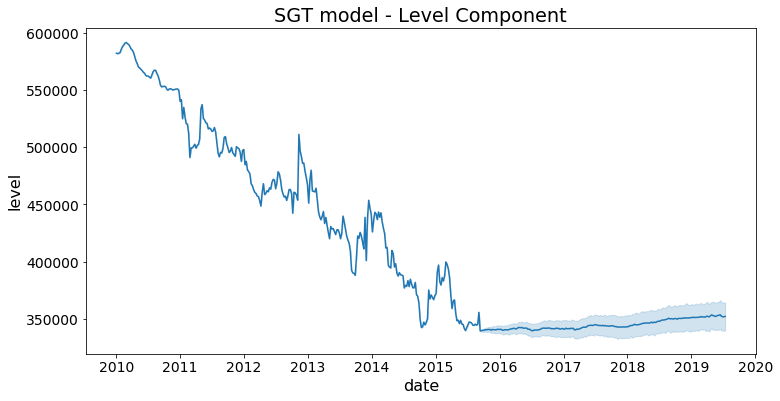

In [147]:
sns.lineplot('date', 'level', data=res1).set_title('SGT model - Level Component');

In [148]:
guide(y_train, periodicity)

{'nu': tensor(2.2277, grad_fn=<ExpandBackward>),
 'sigma': tensor(10928.7305, grad_fn=<ExpandBackward>),
 'alpha': tensor(0.2966, grad_fn=<ExpandBackward>),
 'beta': tensor(0.8204, grad_fn=<ExpandBackward>),
 'gamma': tensor(-0.0038, grad_fn=<ExpandBackward>),
 'pow_trend': tensor(0.0001, grad_fn=<ExpandBackward>),
 'init_seasonality': tensor([1.1178, 1.4207, 1.1299, 0.8683, 0.9085, 0.8624, 0.8134, 0.7696, 0.7999,
         0.7860, 0.7460, 0.7068, 0.7102, 0.7229, 0.8894, 0.7651, 0.7573, 0.7030,
         0.7356, 0.7301, 0.7258, 0.7420, 0.7093, 0.7964, 0.7647, 0.7919, 0.8362,
         0.9230, 0.8982, 0.7251, 0.7018, 0.7454, 0.7147, 0.6894, 0.6872, 0.6933,
         0.6295, 0.6952, 0.6716, 0.6750, 0.8366, 0.7212, 0.7460, 0.7610, 0.8196,
         0.7442, 0.8478, 0.7484, 1.0619, 0.8915, 0.8984, 0.9616],
        grad_fn=<ExpandBackward>)}

### SVI using a Diagonal Normal Autoguide

In [149]:
pyro.clear_param_store()
pyro.set_rng_seed(1)
guide = AutoDiagonalNormal(model_sgt_1)
opt = optim.Adam({'lr': 0.05})

svi = SVI(model_sgt_1, guide, opt, loss=Trace_ELBO())
periodicity = 52  # Use yearly periodicity

for i in range(1600):
    loss = svi.step(periodicity=periodicity, y=y_train)
    if i % 100 == 0:
        print('ELBO loss: {}'.format(loss))
print('ELBO loss: {}'.format(loss))

ELBO loss: 35379.02820235491
ELBO loss: 12200.209919452667
ELBO loss: 8039.517666995525
ELBO loss: 3828.87815707922
ELBO loss: 4014.762809574604
ELBO loss: 3810.3505113720894
ELBO loss: 3718.5378712415695
ELBO loss: 3719.740305840969
ELBO loss: 3779.200146615505
ELBO loss: 3681.39616894722
ELBO loss: 3694.323583960533
ELBO loss: 3690.6980826854706
ELBO loss: 3660.1028146743774
ELBO loss: 3677.033698320389
ELBO loss: 3647.5182954669
ELBO loss: 3623.5569435358047
ELBO loss: 3639.4394859671593


In [150]:
num_samples = 500
predict_ahead = 200
preds, level, seasonality = predict(model_sgt_1, guide, periodicity, y_train, 
                                    predict_ahead=predict_ahead, num_samples=num_samples)

In [151]:
res2 = unemployment.copy()
test_time_range = pd.date_range(start=init_date, freq='7D', 
                                periods=len(y_train) + predict_ahead)
res2['type'] = 'Actual'
l_samples = np.hstack([level.detach().cpu().numpy(),
                       np.full((num_samples, len(preds[1]) - len(level[1])), np.nan)
                      ]).flatten()
s_samples = seasonality.detach().cpu().numpy()[:, :preds.shape[1]].flatten()
df = pd.DataFrame({
    'date': np.tile(test_time_range.values, num_samples),
    'initial claim': preds.flatten().detach().cpu().numpy(),
    'level': l_samples,
    'seasonality': s_samples,
})
df['type'] = 'Predicted'
res2 = res2.append(df, sort=True)

(0, 1000000)

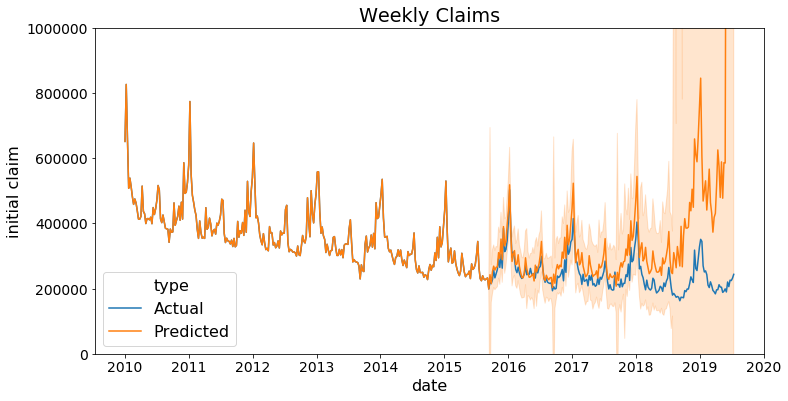

In [152]:
fig, ax = plt.subplots()
sns.lineplot('date', 'initial claim', hue='type', data=res2, ci='sd', ax=ax).set_title('Weekly Claims');
ax.set_ylim(0, 1000000)

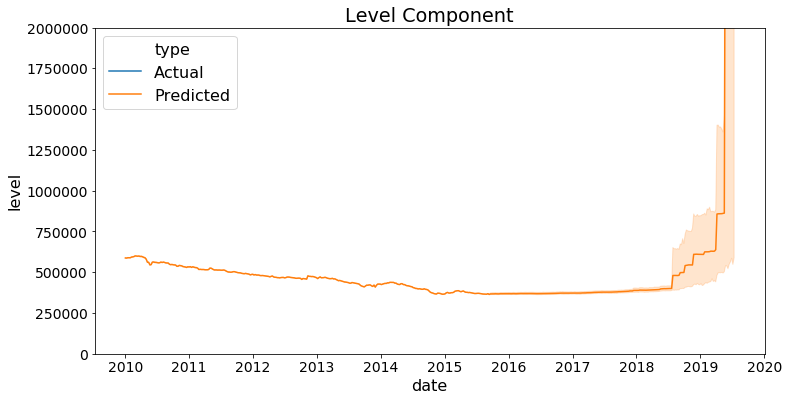

In [175]:
fig, ax = plt.subplots()
sns.lineplot('date', 'level', hue='type', data=res2, ax=ax).set_title('Level Component');
ax.set_ylim(0, 2e6);

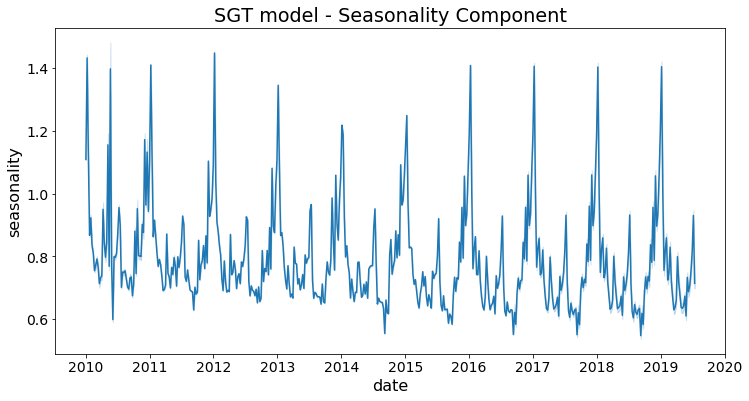

In [176]:
sns.lineplot('date', 'seasonality', data=res2).set_title('SGT model - Seasonality Component');

In [154]:
guide.quantiles([0.2, 0.5, 0.8])

{'nu': [tensor(2.1351, grad_fn=<AddBackward0>),
  tensor(2.1874, grad_fn=<AddBackward0>),
  tensor(2.2597, grad_fn=<AddBackward0>)],
 'sigma': [tensor(17320.1270, grad_fn=<AddBackward0>),
  tensor(20223.9785, grad_fn=<AddBackward0>),
  tensor(23614.6836, grad_fn=<AddBackward0>)],
 'alpha': [tensor(0.0799, grad_fn=<ClampBackward>),
  tensor(0.1038, grad_fn=<ClampBackward>),
  tensor(0.1337, grad_fn=<ClampBackward>)],
 'beta': [tensor(0.9225, grad_fn=<ClampBackward>),
  tensor(0.9438, grad_fn=<ClampBackward>),
  tensor(0.9594, grad_fn=<ClampBackward>)],
 'gamma': [tensor(-1.2873, grad_fn=<ViewBackward>),
  tensor(-0.6779, grad_fn=<ViewBackward>),
  tensor(-0.0685, grad_fn=<ViewBackward>)],
 'pow_trend': [tensor(0.0762, grad_fn=<ClampBackward>),
  tensor(0.1392, grad_fn=<ClampBackward>),
  tensor(0.2407, grad_fn=<ClampBackward>)],
 'init_seasonality': [tensor([1.0822, 1.3345, 0.9378, 0.8062, 0.8452, 0.7192, 0.7211, 0.7005, 0.6571,
          0.7174, 0.6444, 0.5827, 0.6428, 0.5931, 0.7266, 

### Use TransformedDistribution to model positive observations

In [167]:
def model_sgt_2(periodicity, y=None, predict_ahead=0, level=None, seasonality=None):
    """
    A bayesian model for time series forecasting using Seasonal Global Trend (SGT).
     - Note that `tau_var` is assumed to be 0.
    """
    assert (predict_ahead > 0) ^ (y is not None), \
        "Pass `y` for inference, or specify `predict_ahead` > 0 for prediction."
    S = periodicity
    nu = pyro.sample('nu', dist.Uniform(2, 20))
    sigma = pyro.sample('sigma', dist.HalfCauchy(100.))
    alpha = pyro.sample('alpha', dist.Beta(2., 2.)) 
    beta = pyro.sample('beta', dist.Beta(2., 2.))
    gamma = pyro.sample('gamma', dist.Normal(0., 1.))
    pow_trend = pyro.sample('pow_trend', dist.Beta(1., 2.))
    
    with pyro.plate('init_s', S):
        init_seasonality = pyro.sample('init_seasonality', dist.LogNormal(0., 1.))
        
    if y is not None:
        seasonality = [init_seasonality[i] for i in range(periodicity)]
        level = [y[0] / init_seasonality[0]]
        start_idx = 1
    else:
        start_idx = len(level)
    
    forward_steps = len(y) - 1 if y is not None else predict_ahead

    for i in range(start_idx, start_idx + forward_steps):
        seasonality_cur = seasonality[i]
        assert seasonality_cur > 0
        level_prev = level[-1]
        y_hat = (level_prev + gamma * level_prev ** pow_trend) * seasonality_cur
        d = dist.StudentT(nu, y_hat, sigma)
        obs_y = y[i] if y is not None else None
        y_pred = pyro.sample('y_{}'.format(i),
                             dist.TransformedDistribution(dist.StudentT(nu, y_hat.log(), sigma), ExpTransform()),
                             obs=obs_y)
        cur_level = alpha * (y_pred / seasonality_cur) + (1 - alpha) * level_prev
        level.append(cur_level)
        seasonality_next = beta * (y_pred / cur_level) + (1 - beta) * seasonality_cur
        seasonality.append(seasonality_next)

    return [l.detach() for l in level], [s.detach() for s in seasonality]

In [168]:
pyro.clear_param_store()
pyro.set_rng_seed(1)
guide = AutoDelta(model_sgt_1)
opt = optim.Adam({'lr': 0.08})

svi = SVI(model_sgt_2, guide, opt, loss=Trace_ELBO())
periodicity = 52  # Use yearly periodicity

for i in range(600):
    loss = svi.step(periodicity, y=y_train)
    if i % 100 == 0:
        print('ELBO loss: {}'.format(loss))
print('ELBO loss: {}'.format(loss))

ELBO loss: 4154.177262604237
ELBO loss: 3560.440848648548
ELBO loss: 3552.241535782814
ELBO loss: 3552.3391197919846
ELBO loss: 3552.276008248329
ELBO loss: 3552.3278040885925
ELBO loss: 3552.2133107185364


In [169]:
num_samples = 500
predict_ahead = 200
preds, level, seasonality = predict(model_sgt_1, guide, periodicity, y_train, 
                                    predict_ahead=predict_ahead, num_samples=num_samples)

In [170]:
res3 = unemployment.copy()
test_time_range = pd.date_range(start=init_date, freq='7D', 
                                periods=len(y_train) + predict_ahead)
res3['type'] = 'Actual'
l_samples = np.hstack([level.detach().cpu().numpy(),
                       np.full((num_samples, len(preds[1]) - len(level[1])), np.nan)
                      ]).flatten()
s_samples = seasonality.detach().cpu().numpy()[:, :preds.shape[1]].flatten()
df = pd.DataFrame({
    'date': np.tile(test_time_range.values, num_samples),
    'initial claim': preds.flatten().detach().cpu().numpy(),
    'level': l_samples,
    'seasonality': s_samples,
})
df['type'] = 'Predicted'
res3 = res3.append(df, sort=True)

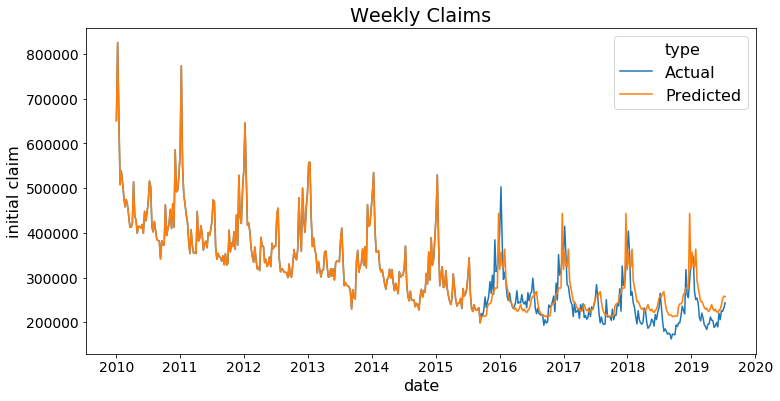

In [172]:
fig, ax = plt.subplots()
sns.lineplot('date', 'initial claim', hue='type', data=res3, ci='sd', ax=ax).set_title('Weekly Claims');